## Zero-Shot and Transfer Learning with CLIP and TensorFlow Hub


In [1]:
# install CLIP dependencies
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q tensorflow tensorflow_hub tensorflow_datasets

  Preparing metadata (setup.py) ... done


In [2]:
# import lib
import torch
import clip
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
# load a image
url = "https://images.unsplash.com/photo-1506744038136-46273834b3fb"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
image = Image.open(BytesIO(response.content)).convert("RGB")
image.show()


# define candidate labels
texts = [
    "a photo of a forest",
    "a photo of a beach",
    "a photo of a city",
    "a photo of farmland",
    "a photo of a snowy mountain"
]

# encode image and text
image_input = preprocess(image).unsqueeze(0).to(device)
text_tokens = clip.tokenize(texts).to(device)

In [4]:
# predict similarity
with torch.no_grad():
    logits_per_image, _ = model(image_input, text_tokens)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# results
for label, prob in zip(texts, probs[0]):
    print(f"{label}: {prob:.4f}")

a photo of a forest: 0.9014
a photo of a beach: 0.0124
a photo of a city: 0.0297
a photo of farmland: 0.0271
a photo of a snowy mountain: 0.0294


In [6]:
# load EuroSAT dataset
(ds_train, ds_val), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

IMG_SIZE = (224, 224)

def preprocess(img, label):
    img = tf.image.resize(img, IMG_SIZE) / 255.0
    return img, label

train_batches = ds_train.map(preprocess).shuffle(1000).batch(32).prefetch(1)
val_batches = ds_val.map(preprocess).batch(32).prefetch(1)

num_classes = ds_info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.P1AJF5_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [8]:
# use EfficientNet
extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
feature_layer = hub.KerasLayer(extractor_url, input_shape=IMG_SIZE + (3,), trainable=False)

# build classification head
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Lambda(lambda x: feature_layer(x)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model
history = model.fit(train_batches, epochs=5, validation_data=val_batches)

Epoch 1/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 236s 345ms/step - accuracy: 0.8288 - loss: 0.6422 - val_accuracy: 0.9465 - val_loss: 0.1828
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 238s 352ms/step - accuracy: 0.9491 - loss: 0.1705 - val_accuracy: 0.9569 - val_loss: 0.1447
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 235s 348ms/step - accuracy: 0.9598 - loss: 0.1315 - val_accuracy: 0.9606 - val_loss: 0.1311
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 236s 349ms/step - accuracy: 0.9641 - loss: 0.1119 - val_accuracy: 0.9633 - val_loss: 0.1235
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 237s 351ms/step - accuracy: 0.9704 - loss: 0.0985 - val_accuracy: 0.9637 - val_loss: 0.1182


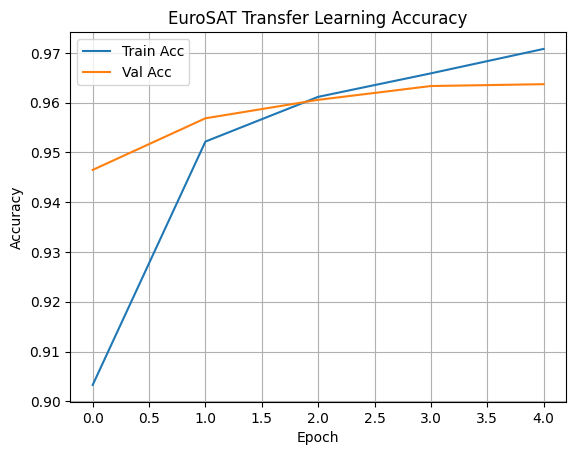

In [9]:
# accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("EuroSAT Transfer Learning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()